# **🎬 Project: Sentiment Analysis with Deep Learning**
Author: meytiii
Description:
This project explores Natural Language Processing (NLP) using TensorFlow and Keras. We will train a neural network to classify movie reviews from the IMDB dataset as either Positive or Negative.

The model uses an Embedding Layer to understand the semantic meaning of words and a Dense network to make the final prediction.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Check version
print(f"TensorFlow Version: {tf.__version__}")

# Helper function to plot training history
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

TensorFlow Version: 2.19.0


# **1. Data Loading & Preprocessing**
We are using the imdb_reviews dataset, which contains 50,000 movie reviews.

Key Steps:

Load Data: Split the dataset into training and testing sets.

Shuffle & Batch: Organize the data for efficient network training.

Text Vectorization: We create an encoder that converts raw text (words) into integers. We limit the vocabulary to the top 1,000 most common words to keep the model fast and lightweight.

In [2]:
# Load the dataset (raw text and labels)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Settings for performance
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the Text Encoder (Vocab size = 1000)
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# "Adapt" the encoder to our specific training data
print("Adapting encoder to the dataset... (this may take a moment)")
encoder.adapt(train_dataset.map(lambda text, label: text))

# Show the first 20 words in our vocabulary
print(f"Vocabulary sample: {encoder.get_vocabulary()[:20]}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.R9XP0N_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.R9XP0N_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.R9XP0N_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Adapting encoder to the dataset... (this may take a moment)
Vocabulary sample: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a'), np.str_('of'), np.str_('to'), np.str_('is'), np.str_('in'), np.str_('it'), np.str_('i'), np.str_('this'), np.str_('that'), np.str_('br'), np.str_('was'), np.str_('as'), np.str_('for'), np.str_('with'), np.str_('movie'), np.str_('but')]


# **2. Building the Neural Network**
We construct a Sequential model with the following layers:

TextVectorization: Converts strings to numbers.

Embedding: Turns those numbers into dense vectors of fixed size, allowing the model to learn that words like "fun" and "exciting" are similar.

GlobalAveragePooling1D: Averages the vectors to flatten the data.

Dense (Relu): The "brain" that learns patterns.

Dense (Output): A single neuron that outputs a score (Positive vs Negative).

In [3]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# **3. Training the Model**
We will train the model for 10 epochs.

We validate against the test set after every epoch to ensure we aren't "overfitting" (memorizing) the data. If the validation accuracy stops improving while training accuracy goes up, that is a sign of overfitting.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5036 - loss: 0.6896 - val_accuracy: 0.4917 - val_loss: 0.6657
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5160 - loss: 0.6450 - val_accuracy: 0.6073 - val_loss: 0.5781
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6786 - loss: 0.5483 - val_accuracy: 0.7375 - val_loss: 0.4870
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7736 - loss: 0.4626 - val_accuracy: 0.7937 - val_loss: 0.4333
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8014 - loss: 0.4207 - val_accuracy: 0.8141 - val_loss: 0.4021
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8232 - loss: 0.3882 - val_accuracy: 0.8229 - val_loss: 0.3821
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8304 - loss: 0.3719 - val_accuracy: 0.8302 - val_loss: 0.3689
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8348 - loss: 0.3633 - val_accu

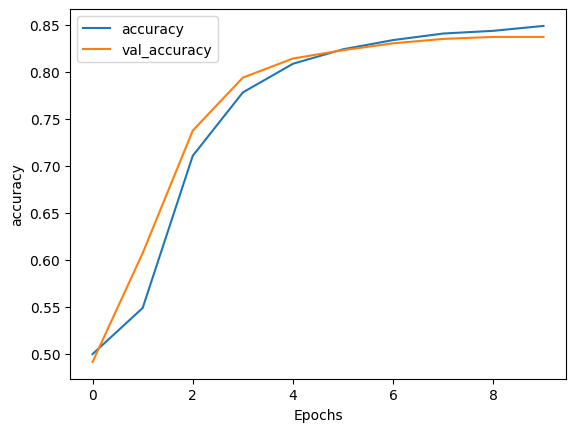

In [4]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

# Visualize accuracy
print("\n--- Training Accuracy ---")
plot_graphs(history, 'accuracy')

# **4. 🧪 Interactive Testing**
Now for the fun part!

Edit the sample_reviews list below with your own made-up movie reviews. Run the cell to see if the model thinks they are Positive or Negative.

In [7]:
# -----------------------------------------------------------
# 👇 TYPE YOUR OWN REVIEWS HERE
# -----------------------------------------------------------
sample_reviews = [
    "The movie was a complete waste of time. I hated the plot.",
    "Absolutely fantastic! I loved the characters and the acting was top notch.",
    "It was okay, not great but not terrible either.",
    "I fell asleep halfway through. Boring!",
    "A masterpiece of modern cinema.",
    "The popcorn was good, but the movie was trash."
]
# -----------------------------------------------------------

print("--- Prediction Results ---\n")

# Use tf.constant to handle the strings correctly
predictions = model.predict(tf.constant(sample_reviews))

for review, score in zip(sample_reviews, predictions):
    # Logits > 0 are positive, < 0 are negative
    sentiment = "😊 POSITIVE" if score > 0 else "😡 NEGATIVE"

    # FIX: Removed the extra [0] here
    prob = tf.sigmoid(score).numpy()[0]

    confidence = prob if prob > 0.5 else 1 - prob

    print(f"Review: '{review}'")
    print(f"Result: {sentiment} ({confidence:.1%} confident)")
    print("-" * 40)

--- Prediction Results ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Review: 'The movie was a complete waste of time. I hated the plot.'
Result: 😡 NEGATIVE (100.0% confident)
----------------------------------------
Review: 'Absolutely fantastic! I loved the characters and the acting was top notch.'
Result: 😊 POSITIVE (99.7% confident)
----------------------------------------
Review: 'It was okay, not great but not terrible either.'
Result: 😡 NEGATIVE (99.9% confident)
----------------------------------------
Review: 'I fell asleep halfway through. Boring!'
Result: 😡 NEGATIVE (100.0% confident)
----------------------------------------
Review: 'A masterpiece of modern cinema.'
Result: 😊 POSITIVE (99.7% confident)
----------------------------------------
Review: 'The popcorn was good, but the movie was trash.'
Result: 😡 NEGATIVE (58.2% confident)
----------------------------------------
